In [61]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from transformers import AutoTokenizer

In [2]:
# Obtain github paths for data downloads
examples_url = "https://github.com/amazon-science/esci-data/raw/main/shopping_queries_dataset/shopping_queries_dataset_examples.parquet"
products_url = "https://github.com/amazon-science/esci-data/raw/main/shopping_queries_dataset/shopping_queries_dataset_products.parquet"

# Download examples with query-product mappings
examples_response = requests.get(examples_url)
with open("../data/raw/examples.parquet", "wb") as f:
    f.write(examples_response.content)
del examples_response # Free up memory before next download

# Download products with product details  
products_response = requests.get(products_url)
with open("../data/raw/products.parquet", "wb") as f:
    f.write(products_response.content)
del products_response # Free up memory from large download

In [2]:
# Load datasets
df_examples = pd.read_parquet("../data/raw/examples.parquet")
df_products = pd.read_parquet("../data/raw/products.parquet")

# Merge on product_locale and product_id, per github repo instructions
df_examples_products = pd.merge(
    df_examples, 
    df_products,
    how='left',
    left_on=['product_locale', 'product_id'],
    right_on=['product_locale', 'product_id']
)

# Preliminary look at the merged dataset
print(f"Dataset shape: {df_examples_products.shape}")
df_examples_products.head()

Dataset shape: (2621288, 14)


,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split,product_title,product_description,product_bullet_point,product_brand,product_color
0,0,revent 80 cfm,0,B000MOO21W,us,I,0,1,train,Panasonic FV-20VQ3 WhisperCeiling 190 CFM Ceil...,None,WhisperCeiling fans feature a totally enclosed...,Panasonic,White
1,1,revent 80 cfm,0,B07X3Y6B1V,us,E,0,1,train,Homewerks 7141-80 Bathroom Fan Integrated LED ...,None,OUTSTANDING PERFORMANCE: This Homewerk's bath ...,Homewerks,80 CFM
2,2,revent 80 cfm,0,B07WDM7MQQ,us,E,0,1,train,Homewerks 7140-80 Bathroom Fan Ceiling Mount E...,None,OUTSTANDING PERFORMANCE: This Homewerk's bath ...,Homewerks,White
3,3,revent 80 cfm,0,B07RH6Z8KW,us,E,0,1,train,Delta Electronics RAD80L BreezRadiance 80 CFM ...,This pre-owned or refurbished product has been...,Quiet operation at 1.5 sones\nBuilt-in thermos...,DELTA ELECTRONICS (AMERICAS) LTD.,White
4,4,revent 80 cfm,0,B07QJ7WYFQ,us,E,0,1,train,Panasonic FV-08VRE2 Ventilation Fan with Reces...,None,The design solution for Fan/light combinations...,Panasonic,White


In [3]:
# Filter for task 1 and target criteria
df_task1 = df_examples_products[df_examples_products["small_version"] == 1]

# Look at the down-sized small version dataset
print(f"Dataset small_version shape: {df_task1.shape}")

# Apply filters for US locale and Exact matches only
df_filtered = df_task1[
    (df_task1['product_locale'] == 'us') & 
    (df_task1['esci_label'] == 'E')
]

# Look at the further filtered dataset
print(f"Dataset filtered shape: {df_filtered.shape}")
print(f"Unique queries: {df_filtered['query'].nunique()}")

# Another quick look at the data
df_filtered.head()

Dataset small_version shape: (1118011, 14)
Dataset filtered shape: (261527, 14)
Unique queries: 29843


,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split,product_title,product_description,product_bullet_point,product_brand,product_color
17,17,!awnmower tires without rims,1,B08L3B9B9P,us,E,1,1,train,MaxAuto 2-Pack 13x5.00-6 2PLY Turf Mower Tract...,MaxAuto 2-Pack 13x5.00-6 2PLY Turf Mower Tract...,Please check your existing tire Sidewall for t...,MaxAuto,None
20,20,!awnmower tires without rims,1,B07C1WZG12,us,E,1,1,train,(Set of 2) 15x6.00-6 Husqvarna/Poulan Tire Whe...,No fuss. Just take off your old assembly and r...,Tire size:15x6.00-6 Ply: 4 Tubeless\n6x4.5 Whe...,Antego Tire & Wheel,Husqvarna Silver
21,21,!awnmower tires without rims,1,B077QMNXTS,us,E,1,1,train,MaxAuto 2 Pcs 16x6.50-8 Lawn Mower Tire for Ga...,<br>Tire Specifications:<br> 1. Material: Rubb...,"Set of 2 16X6.50-8, 16x6.50x8, 16-6.50-8 Lawn ...",MaxAuto,Black
23,23,!awnmower tires without rims,1,B06XX6BM2R,us,E,1,1,train,"MARASTAR 21446-2PK 15x6.00-6"" Front Tire Assem...",None,Tire: 2 pack 15x6. 00-6 tube-type turf SAVER t...,MARASTAR,None
26,26,!awnmower tires without rims,1,B0089RNSNM,us,E,1,1,train,Honda 42710-VE2-M02ZE (Replaces 42710-VE2-M01Z...,Honda 42710-VE2-M02ZE (Replaces 42710-VE2-M01Z...,Set of 2 Honda OEM Rear Wheels\nReplaces 42710...,Honda,None


* Notice '!' exclamation point instead of 'l' for the first letter in lawnmower for query column.
  * Reiterates that text cleanup likely but maybe need to allow typos for user-generated queries

In [4]:
# Further look at the data before down-sampling
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261527 entries, 17 to 2618569
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   example_id            261527 non-null  int64 
 1   query                 261527 non-null  object
 2   query_id              261527 non-null  int64 
 3   product_id            261527 non-null  object
 4   product_locale        261527 non-null  object
 5   esci_label            261527 non-null  object
 6   small_version         261527 non-null  int64 
 7   large_version         261527 non-null  int64 
 8   split                 261527 non-null  object
 9   product_title         261527 non-null  object
 10  product_description   134067 non-null  object
 11  product_bullet_point  231366 non-null  object
 12  product_brand         249806 non-null  object
 13  product_color         184355 non-null  object
dtypes: int64(4), object(10)
memory usage: 29.9+ MB


* Many missing values for the 'product_' related columns:
  * ~51% for 'product_description' are missing!
  * ~11% for 'product_bullet_point' are missing
  * ~4% for 'product_brand' are missing
  * ~29% for 'product_color' are missing
* Some missing information may be likely for a product distributor, such as Amazon, if not provided by the manufacturer.
* However, distributors may likely try to obtain all product info before listing:
  * May be worth exploring if there is a way to drop null values before creating sample dataset

In [9]:
# Save current filtered dataset
df_filtered.to_parquet("../data/processed/df_filtered.parquet")

## Checkpoint 1

In [10]:
# Checkpoint to reload filtered dataset
df_filtered = pd.read_parquet("../data/processed/df_filtered.parquet")

In [5]:
# Drop null values for the 'product_' related columns
df_dropped = df_filtered.dropna(subset=['product_description', 'product_bullet_point', 'product_brand', 'product_color']).reset_index(drop=True)

# Look at the data again before trying down-sampling
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93296 entries, 0 to 93295
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   example_id            93296 non-null  int64 
 1   query                 93296 non-null  object
 2   query_id              93296 non-null  int64 
 3   product_id            93296 non-null  object
 4   product_locale        93296 non-null  object
 5   esci_label            93296 non-null  object
 6   small_version         93296 non-null  int64 
 7   large_version         93296 non-null  int64 
 8   split                 93296 non-null  object
 9   product_title         93296 non-null  object
 10  product_description   93296 non-null  object
 11  product_bullet_point  93296 non-null  object
 12  product_brand         93296 non-null  object
 13  product_color         93296 non-null  object
dtypes: int64(4), object(10)
memory usage: 10.0+ MB


* Full dataset with no missing values has ~93k records:
  * Try ~500 row / 50 unique query sample dataset creation

In [8]:
# Create sample dataset: ~500 rows with ~50 unique queries
np.random.seed(2025) # set random seed for reproducibility (like to use the year)
unique_queries = df_dropped['query'].unique()

# Sample 50 queries randomly
n_queries = min(50, len(unique_queries))
sample_queries = np.random.choice(unique_queries, size=n_queries, replace=False)

# Get all products for these queries
df_sample = df_dropped[df_dropped['query'].isin(sample_queries)].copy()

# If too many rows, sample proportionally per query
if df_sample.shape[0] > 500:
    target_per_query = max(1, 500 // n_queries)
    df_sample = df_sample.groupby('query').apply(
        lambda x: x.sample(n=min(len(x), target_per_query), random_state=2025)
    ).reset_index(drop=True)
else:
    df_sample = df_sample.reset_index(drop=True)

print(f"Final sample: {df_sample.shape[0]} rows, {df_sample['query'].nunique()} queries")

# Look at the sample dataset head
# df_sample[['query', 'product_title']].head()
df_sample.head()

Final sample: 210 rows, 50 queries


,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split,product_title,product_description,product_bullet_point,product_brand,product_color
0,117965,6 acrylic brushes for nails,4839,B087CJ6ZVV,us,E,1,1,test,"Yolife Acrylic Nail Art Brush, 100% Pure Kolin...",<b>Package Content: </b><p>1* Red Wooden Nail ...,❤️【Ingenious Design】100% Pure Kolinsky Sable N...,Yolife,Wood
1,117966,6 acrylic brushes for nails,4839,B083ZMG2ZX,us,E,1,1,test,Pana USA Acrylic Nail Brush100% Pure Kolinsky ...,PANA Finest Kolinsky Hair Professional Acrylic...,[Design] Size 6 Brush Handle | A smooth and st...,PANA,Mahogany
2,117967,6 acrylic brushes for nails,4839,B07Y55F8HH,us,E,1,1,test,1PCS Eval 100% Kolinsky Sable hair Brushes Acr...,Eval Crimped Shaped Kolinsky Sable Brushes #6 ...,★HIGH QUALITY HAIR:Brushes made of Kolinsky sa...,Eval,Purple
3,137801,a 6 motels,5780,B07MTMP7D5,us,E,1,1,train,"Evocel Galaxy A6 (2018) Case, [Explorer Series...",The Evocel Explorer Series Pro is a phone case...,"[Dependable Protection] Heavy duty, dual layer...",Evocel,Blue
4,137803,a 6 motels,5780,B0796M8RPJ,us,E,1,1,train,Aunifun Replacement Filter & Side Brush Kit fo...,<b>Fit for</b> ILIFE A6 A4 A4s Robot Vacuum Cl...,★Fit for ILIFE A6 A4 A4s Robot Vacuum Cleaner....,Aunifun,Replacement Filter & Side Brush Kit for ILIFE ...


* Only able to sample to 210 rows from non-null ~93k dataset:
  * Likely need to accept some missing 'product_' values and develop imputation strategy
* Turn down-sampling into defined function and try different ways to handle missing values
  * Include original non-null down-sampling for good measure

In [7]:
def iterative_downsample(
    df: pd.DataFrame,
    subset_columns: list,
    target_rows: int = 500,
    target_queries: int = 50,
    random_seed: int = 2025
):
    np.random.seed(random_seed) # set random seed for reproducibility (like to use the year)
    
    def downsample(df_input):
        """Downsample df_input to the target number of queries and rows."""
        unique_queries = df_input['query'].unique()
        # Sample 50 queries randomly
        n_queries = min(target_queries, len(unique_queries))
        sample_queries = np.random.choice(unique_queries, size=n_queries, replace=False)
        # Get all products for these queries
        df_sample = df_input[df_input['query'].isin(sample_queries)].copy()
        
        # If too many rows, sample proportionally per query
        if df_sample.shape[0] > target_rows:
            target_per_query = max(1, target_rows // n_queries)
            df_sample = df_sample.groupby('query').apply(
                lambda x: x.sample(n=min(len(x), target_per_query), random_state=random_seed)
            ).reset_index(drop=True)
        else:
            df_sample = df_sample.reset_index(drop=True)

        return df_sample

    # Track results
    results = {}

    # Start with dropping all nulls from all specified columns
    current_cols = subset_columns.copy()
    df_dropped = df.dropna(subset=current_cols).reset_index(drop=True)
    df_sample = downsample(df_dropped)
    results['no_nulls'] = df_sample
    print(f"Sample with no nulls: {df_sample.shape[0]} rows, {df_sample['query'].nunique()} queries")

    # Check what results would be for allowing nulls for each column, one at a time
    for col in subset_columns:
        current_cols = [c for c in subset_columns if c != col]
        df_partial = df.dropna(subset=current_cols).reset_index(drop=True)
        df_sample = downsample(df_partial)
        results[f"{col}_nulls_allowed"] = df_sample
        print(f"Sample with {col} nulls: {df_sample.shape[0]} rows, {df_sample['query'].nunique()} queries")

    return results

In [8]:
subset_cols = ['product_description', 'product_bullet_point', 'product_brand', 'product_color']

sampled_dfs = iterative_downsample(df_filtered, subset_columns=subset_cols)

Sample with no nulls: 210 rows, 50 queries
Sample with product_description nulls: 294 rows, 50 queries
Sample with product_bullet_point nulls: 224 rows, 50 queries
Sample with product_brand nulls: 256 rows, 50 queries
Sample with product_color nulls: 246 rows, 50 queries


* Decide to allow null values as representative of real world problem
  * Define function to down-sample and coerce to row and query targets

In [36]:
def create_sample_dataset(
    df: pd.DataFrame,
    target_queries: int = 50,
    target_rows: int = 500,
    random_seed: int = 2025, 
    prioritize='rows', 
    max_queries=100
    ):
    """
    Create a sample dataset to meet both row and query targets.
    Allow to prioritize rows or queries, with preference for rows.
    Allow to set max queries to sample when prioritizing rows.
    """
    np.random.seed(random_seed)
    
    # Get query-level statistics to help with sampling
    query_counts = df['query'].value_counts()
    # Reduce skew from too little or too many rows per query (keep from 5-20 for even distribution)
    unique_queries = query_counts[(query_counts >= 5) & (query_counts <= 20)].index.tolist()
    ##  unique_queries = query_counts.index.tolist()
    print(f"Total unique queries available: {len(unique_queries)}")
    print(f"Query product counts - Min: {query_counts.min()}, Max: {query_counts.max()}, Mean: {query_counts.mean():.1f}")
    
    if prioritize == 'rows':
        print(f"\nPrioritizing hitting {target_rows} rows target...")
        
        # Strategy: Start with target_queries, increase if needed to hit row target
        current_queries = min(target_queries, len(unique_queries))
        
        for attempt_queries in range(current_queries, min(max_queries + 1, len(unique_queries) + 1)):
            # Sample queries
            sample_queries = np.random.choice(unique_queries, size=attempt_queries, replace=False)
            df_query_filtered = df[df['query'].isin(sample_queries)].copy()
            
            print(f"  Trying {attempt_queries} queries: {df_query_filtered.shape[0]} total rows")
            
            if df_query_filtered.shape[0] >= target_rows:
                print(f"  * Found {attempt_queries} queries with {df_query_filtered.shape[0]} rows (>= {target_rows})")
                
                # Now sample down to exactly target_rows
                if df_query_filtered.shape[0] > target_rows:
                    df_sample = df_query_filtered.sample(n=target_rows, random_state=random_seed).reset_index(drop=True)
                else:
                    df_sample = df_query_filtered.reset_index(drop=True)
                
                break
        else:
            # If we couldn't hit target_rows even with max_queries, use what we have
            print(f"  Could not reach {target_rows} rows even with {max_queries} queries")
            print(f"  Using all {df_query_filtered.shape[0]} rows from {attempt_queries} queries")
            df_sample = df_query_filtered.reset_index(drop=True)
    
    else:  # prioritize == 'queries'
        print(f"\nPrioritizing hitting {target_queries} queries target...")
        
        # Original strategy: sample exactly target_queries, then work with available rows
        n_queries = min(target_queries, len(unique_queries))
        sample_queries = np.random.choice(unique_queries, size=n_queries, replace=False)
        df_query_filtered = df[df['query'].isin(sample_queries)].copy()
        
        print(f"Sampled {n_queries} queries with {df_query_filtered.shape[0]} total rows")
        
        if df_query_filtered.shape[0] > target_rows:
            # Sample down proportionally per query
            rows_per_query = target_rows // n_queries
            remainder = target_rows % n_queries
            
            sampled_dfs = []
            queries_list = list(sample_queries)
            
            for i, query in enumerate(queries_list):
                query_df = df_query_filtered[df_query_filtered['query'] == query]
                n_rows_for_query = rows_per_query + (1 if i < remainder else 0)
                n_rows_for_query = min(n_rows_for_query, len(query_df))
                
                if n_rows_for_query > 0:
                    sampled_query_df = query_df.sample(n=n_rows_for_query, random_state=random_seed+i)
                    sampled_dfs.append(sampled_query_df)
            
            df_sample = pd.concat(sampled_dfs, ignore_index=True)
        else:
            df_sample = df_query_filtered.reset_index(drop=True)
    
    print(f"\nFinal sample dataset: {df_sample.shape[0]} rows, {df_sample['query'].nunique()} unique queries")
    
    # Show missing value counts for product columns
    product_cols = ['product_description', 'product_bullet_point', 'product_brand', 'product_color']
    print(f"\nMissing values in product columns:")
    for col in product_cols:
        if col in df_sample.columns:
            missing_count = df_sample[col].isna().sum()
            missing_pct = (missing_count / len(df_sample)) * 100
            print(f"  {col}: {missing_count} ({missing_pct:.1f}%)")

    # Return both the sampled down and unsampled datasets    
    return df_sample.reset_index(drop=True), df_query_filtered.reset_index(drop=True)

In [37]:
# Try the down-sampling prioritizing rows to hit the 500 target
df_sampled_rows, df_query_filtered_rows = create_sample_dataset(
    df_filtered, 
    target_queries=50, 
    target_rows=500, 
    random_seed=2025, 
    prioritize='rows',
    max_queries=100
)

Total unique queries available: 18877
Query product counts - Min: 1, Max: 81, Mean: 8.8

Prioritizing hitting 500 rows target...
  Trying 50 queries: 481 total rows
  Trying 51 queries: 476 total rows
  Trying 52 queries: 485 total rows
  Trying 53 queries: 519 total rows
  * Found 53 queries with 519 rows (>= 500)

Final sample dataset: 500 rows, 53 unique queries

Missing values in product columns:
  product_description: 221 (44.2%)
  product_bullet_point: 57 (11.4%)
  product_brand: 18 (3.6%)
  product_color: 144 (28.8%)


In [38]:
# Try the down-sampling prioritizing queries to hit the 50 target
df_sampled_queries, df_query_filtered_queries = create_sample_dataset(
    df_filtered, 
    target_queries=50, 
    target_rows=500, 
    random_seed=2025, 
    prioritize='queries'
)

Total unique queries available: 18877
Query product counts - Min: 1, Max: 81, Mean: 8.8

Prioritizing hitting 50 queries target...
Sampled 50 queries with 481 total rows

Final sample dataset: 481 rows, 50 unique queries

Missing values in product columns:
  product_description: 267 (55.5%)
  product_bullet_point: 53 (11.0%)
  product_brand: 22 (4.6%)
  product_color: 129 (26.8%)


* Prioritizing rows resulted in dataframes meeting required dataset sample sizes but prioritizing queries did not
* Move forward with exploring row-prioritized dataframes:
  *  Choose to accept slightly larger amount of rows or not through exploration

In [39]:
df_sampled_rows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   example_id            500 non-null    int64 
 1   query                 500 non-null    object
 2   query_id              500 non-null    int64 
 3   product_id            500 non-null    object
 4   product_locale        500 non-null    object
 5   esci_label            500 non-null    object
 6   small_version         500 non-null    int64 
 7   large_version         500 non-null    int64 
 8   split                 500 non-null    object
 9   product_title         500 non-null    object
 10  product_description   279 non-null    object
 11  product_bullet_point  443 non-null    object
 12  product_brand         482 non-null    object
 13  product_color         356 non-null    object
dtypes: int64(4), object(10)
memory usage: 54.8+ KB


In [40]:
df_query_filtered_rows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   example_id            519 non-null    int64 
 1   query                 519 non-null    object
 2   query_id              519 non-null    int64 
 3   product_id            519 non-null    object
 4   product_locale        519 non-null    object
 5   esci_label            519 non-null    object
 6   small_version         519 non-null    int64 
 7   large_version         519 non-null    int64 
 8   split                 519 non-null    object
 9   product_title         519 non-null    object
 10  product_description   289 non-null    object
 11  product_bullet_point  459 non-null    object
 12  product_brand         501 non-null    object
 13  product_color         368 non-null    object
dtypes: int64(4), object(10)
memory usage: 56.9+ KB


In [41]:
# Save dfs to parquet and csv for checkpointing
df_sampled_rows.to_parquet("../data/processed/df_sampled_rows.parquet")
df_sampled_rows.to_csv("../data/processed/df_sampled_rows.csv", index=False)
df_query_filtered_rows.to_parquet("../data/processed/df_query_filtered_rows.parquet")
df_query_filtered_rows.to_csv("../data/processed/df_query_filtered_rows.csv", index=False)

In [42]:
# Quick check to look at query distribution for n=500
df_sampled_rows['query'].value_counts()

query
cold rush cold therapy system                                  18
bulk tobacco for smoking                                       18
chic throw pillows                                             17
1 cup coffee maker without water reservoir                     16
stand mixer                                                    16
rotator cuff pillow                                            15
1 fluid ounce empty mini sauce bottles (sauce not included)    14
black stockings for women                                      14
calcium supplement without vitamin d3                          14
fabric                                                         13
20s gala dresses                                               12
slide for bed without bed                                      12
ant man                                                        11
attract customer candle                                        11
apple travel chargers                                          11
blue

In [43]:
# Quick check to look at query distribution for n=519
df_query_filtered_rows['query'].value_counts()

query
cold rush cold therapy system                                  19
chic throw pillows                                             19
1 cup coffee maker without water reservoir                     18
bulk tobacco for smoking                                       18
stand mixer                                                    16
rotator cuff pillow                                            15
black stockings for women                                      15
1 fluid ounce empty mini sauce bottles (sauce not included)    14
calcium supplement without vitamin d3                          14
20s gala dresses                                               13
fabric                                                         13
google pixel 3 charger                                         12
slide for bed without bed                                      12
blue lightsaber                                                12
iphone x screen replacement                                    11
flor

* Select df_query_filtered_rows as df moving forward since down-sampling to 500 made lowest query to <5 
# Checkpoint for visualizations

In [44]:
df = df_query_filtered_rows.copy()

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   example_id            519 non-null    int64 
 1   query                 519 non-null    object
 2   query_id              519 non-null    int64 
 3   product_id            519 non-null    object
 4   product_locale        519 non-null    object
 5   esci_label            519 non-null    object
 6   small_version         519 non-null    int64 
 7   large_version         519 non-null    int64 
 8   split                 519 non-null    object
 9   product_title         519 non-null    object
 10  product_description   289 non-null    object
 11  product_bullet_point  459 non-null    object
 12  product_brand         501 non-null    object
 13  product_color         368 non-null    object
dtypes: int64(4), object(10)
memory usage: 56.9+ KB


In [46]:
df.head()

,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split,product_title,product_description,product_bullet_point,product_brand,product_color
0,20232,1 cup coffee maker without water reservoir,711,B07GV2S1GS,us,E,1,1,train,"Keurig K-Mini Coffee Maker, Single Serve K-Cup...",None,"FITS ANYWHERE: Less than 5 inches wide, perfec...",Keurig,Black
1,20235,1 cup coffee maker without water reservoir,711,B07Q5CG2MH,us,E,1,1,train,Hamilton Beach FlexBrew Single-Serve Maker wit...,None,Single-Serve Coffee Maker With or Without K-Cu...,Hamilton Beach,Black and Silver
2,20239,1 cup coffee maker without water reservoir,711,B07ZHNDYDY,us,E,1,1,train,"CHEFMAN Single Serve One Cup Coffee Maker, up ...",None,FAST BREW TIME: With this single serve coffee ...,Chefman,Instacoffe Single Serve Coffee Maker
3,20242,1 cup coffee maker without water reservoir,711,B088WMVG9D,us,E,1,1,train,EZBASICS Single Serve Coffee Maker Brewer Comp...,EZBASICS Single Serve Coffee Brewer features a...,Compatible with K-Cup or Ground Coffee - This ...,EZBASICS,black
4,20244,1 cup coffee maker without water reservoir,711,B08C4VZ252,us,E,1,1,train,"CHULUX Single Cup Coffee Maker Machine,12 Ounc...",coffee maker,【Single Cup Coffee Design】CHULUX coffee machin...,CHULUX,Cyan


In [47]:
df['query'].value_counts()

query
cold rush cold therapy system                                  19
chic throw pillows                                             19
1 cup coffee maker without water reservoir                     18
bulk tobacco for smoking                                       18
stand mixer                                                    16
rotator cuff pillow                                            15
black stockings for women                                      15
1 fluid ounce empty mini sauce bottles (sauce not included)    14
calcium supplement without vitamin d3                          14
20s gala dresses                                               13
fabric                                                         13
google pixel 3 charger                                         12
slide for bed without bed                                      12
blue lightsaber                                                12
iphone x screen replacement                                    11
flor

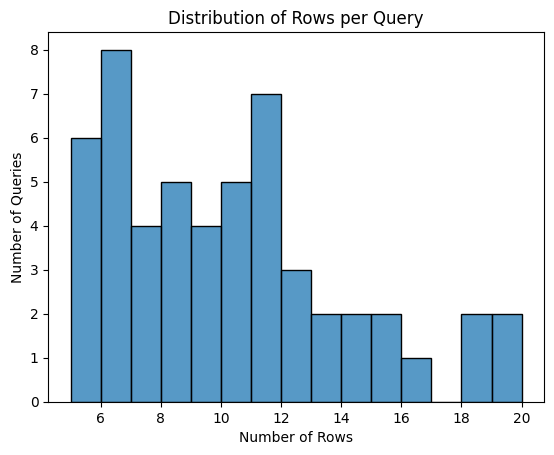

In [48]:
# View histogram of row distributions for each query
sns.histplot(df['query'].value_counts(), bins=range(5, 21), edgecolor='black')
plt.title("Distribution of Rows per Query")
plt.xlabel("Number of Rows")
plt.ylabel("Number of Queries")
plt.show()

In [49]:
# Create initial profile report of selected down-sampled dataset
initial_profile_report = ProfileReport(df, title="Initial Semantic Search Profiling Report")
initial_profile_report.to_file("../data/processed/initial_profile_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Profile report observations:
* Drop univariate columns: 
  * 'product_locale' - filtered to "us",
  * 'esci_label' - filtered to "E",
  * 'small_version' - always "1",
  * 'large_version' - always "1"
* Missing value proportions similar to pre down-sampling levels:
  * 'product_description' - 230 (44.3%) missing values,
  * 'product_bullet_point' - 60 (11.6%) missing values,
  * 'product_brand' - 18 (3.5%) missing values,
  * 'product_color' - 151 (29.1%) missing values
* 'example_id':
  * All unique entries (original index)
* Column 'split' maintains train/test split of ~73%/27%
  * n=519 samples likely too small to utilize split but will retain
* 'query':
  * Character length stats: max=59, median=32, mean=23.3, min=6
  * 53 distinct queries
* 'product_id':
  * All unique entries
  * Always 10 characters
* 'product_title':
  * Character length stats: max=213, median=148, mean=109.8, min=8
* 'product_description':
  * Character length stats: max=1995, median=876, mean=863.6, min=2 (really 0 since some missing)
* 'product_bullet_point':
  * Character length stats: max=2479, median=823, mean=737.2, min=7 (really 0 since some missing)
* 'product_brand':
  * Character length stats: max=46, median=30, mean=8.8, min=2 (really 0 since some missing)
* 'product_color':
  * Character length stats: max=49, median=38, mean=9.3, min=1 (really 0 since some missing)

In [50]:
# Drop univariate columns
df = df.drop(columns=['product_locale', 'esci_label', 'small_version', 'large_version']).reset_index(drop=True)
df.head()

,example_id,query,query_id,product_id,split,product_title,product_description,product_bullet_point,product_brand,product_color
0,20232,1 cup coffee maker without water reservoir,711,B07GV2S1GS,train,"Keurig K-Mini Coffee Maker, Single Serve K-Cup...",None,"FITS ANYWHERE: Less than 5 inches wide, perfec...",Keurig,Black
1,20235,1 cup coffee maker without water reservoir,711,B07Q5CG2MH,train,Hamilton Beach FlexBrew Single-Serve Maker wit...,None,Single-Serve Coffee Maker With or Without K-Cu...,Hamilton Beach,Black and Silver
2,20239,1 cup coffee maker without water reservoir,711,B07ZHNDYDY,train,"CHEFMAN Single Serve One Cup Coffee Maker, up ...",None,FAST BREW TIME: With this single serve coffee ...,Chefman,Instacoffe Single Serve Coffee Maker
3,20242,1 cup coffee maker without water reservoir,711,B088WMVG9D,train,EZBASICS Single Serve Coffee Maker Brewer Comp...,EZBASICS Single Serve Coffee Brewer features a...,Compatible with K-Cup or Ground Coffee - This ...,EZBASICS,black
4,20244,1 cup coffee maker without water reservoir,711,B08C4VZ252,train,"CHULUX Single Cup Coffee Maker Machine,12 Ounc...",coffee maker,【Single Cup Coffee Design】CHULUX coffee machin...,CHULUX,Cyan


In [51]:
# Save dfs to parquet and csv for checkpointing
df.to_parquet("../data/processed/df.parquet")
df.to_csv("../data/processed/df.csv", index=False)

## Checkpoint for df load

In [52]:
df_load = pd.read_parquet("../data/processed/df.parquet")
df = df_load.copy()

In [ ]:
# Create text length features
text_columns = ['product_title', 'product_description', 'product_bullet_point', 'product_brand', 'product_color']

for col in text_columns:
    df[f'{col}_len'] = df[col].fillna('').apply(len)


In [58]:
# Plot text length distributions
def plot_length_histograms(df, columns, bins=30):
    plt.figure(figsize=(15, 12))
    
    for i, col in enumerate(columns):
        plt.subplot(3, 2, i+1)
        length_col = f"{col}_len"
        
        if length_col in df.columns:
            sns.histplot(df[length_col], bins=bins, kde=False, color='skyblue', edgecolor='black')
            plt.title(f'Character Length Distribution: {col}')
            plt.xlabel('Length')
            plt.ylabel('Count')
        else:
            plt.text(0.5, 0.5, f'{length_col} not found', ha='center')
    
    plt.tight_layout()
    plt.show()

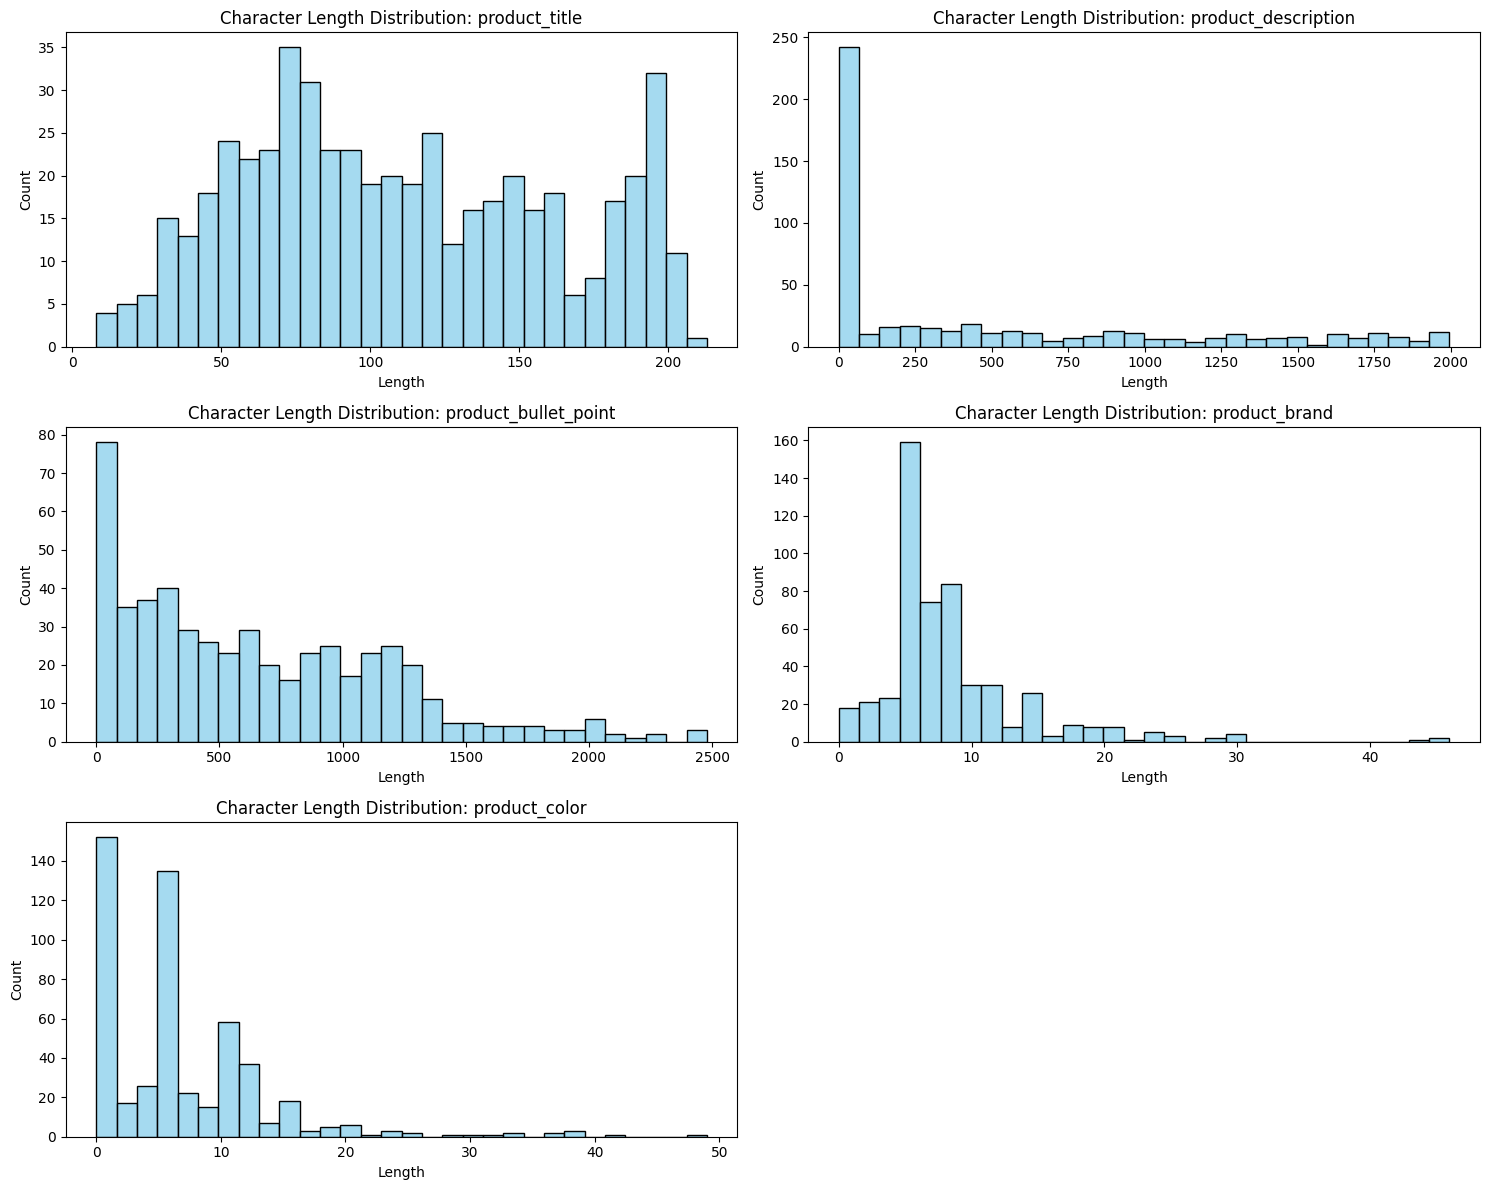

In [59]:
plot_length_histograms(df, text_columns)

In [75]:
# Create token length features
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

for col in text_columns:
    df[f'{col}_tokens'] = df[col].fillna('').apply(lambda x: len(tokenizer.tokenize(x)))

Token indices sequence length is longer than the specified maximum sequence length for this model (700 > 512). Running this sequence through the model will result in indexing errors


In [76]:
# Plot text length distributions
def plot_token_length_histograms(df, columns, bins=30):
    plt.figure(figsize=(15, 12))
    
    for i, col in enumerate(columns):
        plt.subplot(3, 2, i+1)
        token_col = f"{col}_tokens"
        
        if token_col in df.columns:
            sns.histplot(df[token_col], bins=bins, kde=False, color='skyblue', edgecolor='black')
            plt.title(f'Token Length Distribution: {col}')
            plt.xlabel('Token Length')
            plt.ylabel('Count')
        else:
            plt.text(0.5, 0.5, f'{token_col} not found', ha='center')
    
    plt.tight_layout()
    plt.show()

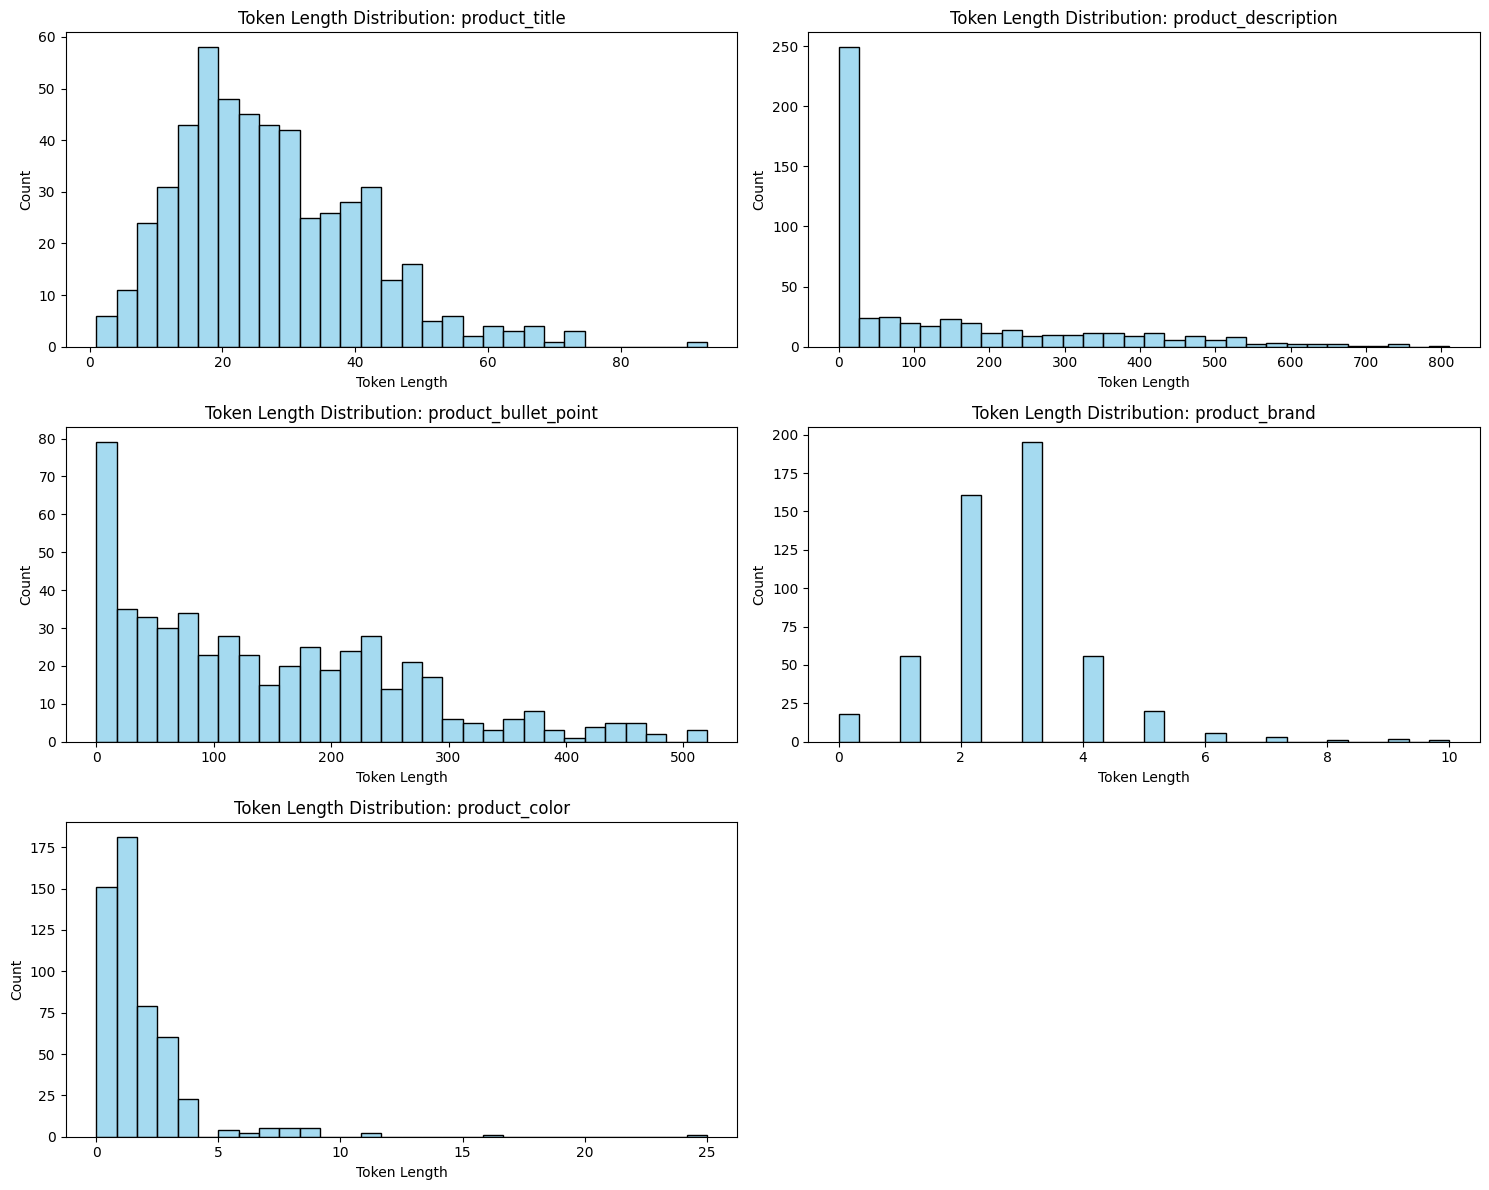

In [77]:
plot_token_length_histograms(df, text_columns)

In [78]:
print(df['product_bullet_point_tokens'].max())

520


* Notice many values for product_description are over 512 tokens so would need truncation for many embedding methods.
* Notice that there are a small amount of values for product_bullet_points that would be over 512 too. 

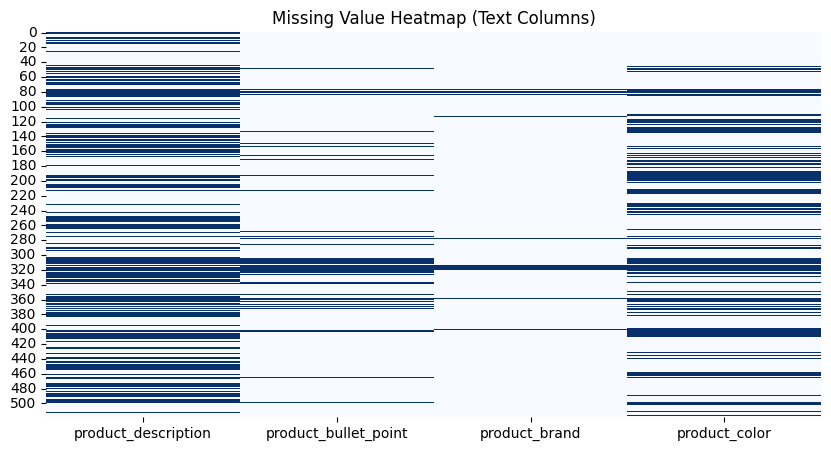

In [65]:
# Is there patterns in the missing data?
heatmap_cols = [col for col in text_columns if col != 'product_title']
plt.figure(figsize=(10, 5))
sns.heatmap(df[heatmap_cols].isnull(), cbar=False, cmap='Blues')
plt.title("Missing Value Heatmap (Text Columns)")
plt.show()

* No strong row-wise pattern for missing values but maybe possible to impute product description from bullet points?

In [79]:
# Look at query overlap with the product related columns
def add_query_overlap_metrics(df, text_columns):
    def normalize(text):
        return str(text).lower().split()
    
    for col in text_columns:
        col_suffix = col.replace("product_", "")
        
        # Basic 'in' check
        contains_col = f'query_in_{col_suffix}'
        df[contains_col] = df.apply(lambda x: x['query'].lower() in str(x[col]).lower(), axis=1)

        # Word-level set operations
        count_col = f'overlap_count_{col_suffix}'
        ratio_q_col = f'overlap_ratio_query_{col_suffix}'
        jaccard_col = f'jaccard_sim_{col_suffix}'
        
        def compute_overlap(row):
            q_words = set(normalize(row['query']))
            p_words = set(normalize(row[col]))

            if not q_words or not p_words:
                return pd.Series([0, 0.0, 0.0])

            overlap = q_words.intersection(p_words)
            overlap_count = len(overlap)
            ratio_query = overlap_count / len(q_words)
            jaccard = len(overlap) / len(q_words.union(p_words))

            return pd.Series([overlap_count, ratio_query, jaccard])
        
        df[[count_col, ratio_q_col, jaccard_col]] = df.apply(compute_overlap, axis=1)
        
    return df

In [80]:
df = add_query_overlap_metrics(df, text_columns)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   example_id                        519 non-null    int64  
 1   query                             519 non-null    object 
 2   query_id                          519 non-null    int64  
 3   product_id                        519 non-null    object 
 4   split                             519 non-null    object 
 5   product_title                     519 non-null    object 
 6   product_description               289 non-null    object 
 7   product_bullet_point              459 non-null    object 
 8   product_brand                     501 non-null    object 
 9   product_color                     368 non-null    object 
 10  product_title_len                 519 non-null    int64  
 11  product_description_len           519 non-null    int64  
 12  product_

In [82]:
df.head()

,example_id,query,query_id,product_id,split,product_title,product_description,product_bullet_point,product_brand,product_color,...,overlap_ratio_query_bullet_point,jaccard_sim_bullet_point,query_in_brand,overlap_count_brand,overlap_ratio_query_brand,jaccard_sim_brand,query_in_color,overlap_count_color,overlap_ratio_query_color,jaccard_sim_color
0,20232,1 cup coffee maker without water reservoir,711,B07GV2S1GS,train,"Keurig K-Mini Coffee Maker, Single Serve K-Cup...",None,"FITS ANYWHERE: Less than 5 inches wide, perfec...",Keurig,Black,...,0.428571,0.062500,False,0.0,0.0,0.0,False,0.0,0.000000,0.0
1,20235,1 cup coffee maker without water reservoir,711,B07Q5CG2MH,train,Hamilton Beach FlexBrew Single-Serve Maker wit...,None,Single-Serve Coffee Maker With or Without K-Cu...,Hamilton Beach,Black and Silver,...,0.857143,0.056075,False,0.0,0.0,0.0,False,0.0,0.000000,0.0
2,20239,1 cup coffee maker without water reservoir,711,B07ZHNDYDY,train,"CHEFMAN Single Serve One Cup Coffee Maker, up ...",None,FAST BREW TIME: With this single serve coffee ...,Chefman,Instacoffe Single Serve Coffee Maker,...,0.428571,0.021429,False,0.0,0.0,0.0,False,2.0,0.285714,0.2
3,20242,1 cup coffee maker without water reservoir,711,B088WMVG9D,train,EZBASICS Single Serve Coffee Maker Brewer Comp...,EZBASICS Single Serve Coffee Brewer features a...,Compatible with K-Cup or Ground Coffee - This ...,EZBASICS,black,...,0.428571,0.025641,False,0.0,0.0,0.0,False,0.0,0.000000,0.0
4,20244,1 cup coffee maker without water reservoir,711,B08C4VZ252,train,"CHULUX Single Cup Coffee Maker Machine,12 Ounc...",coffee maker,【Single Cup Coffee Design】CHULUX coffee machin...,CHULUX,Cyan,...,0.857143,0.046154,False,0.0,0.0,0.0,False,0.0,0.000000,0.0
